# Generative Perturbation Analysis for Probabilistic Black-Box Anomaly Attribution

Tsuyoshi Ide 
tide@us.ibm.com, IBM Thomas J. Watson Research Center.

August 1, 2023

This notebook maintains the reference implementation of *generative perturbation analysis (GPA)* by the authors, based on a paper presented at KDD 2023:

> Tsuyoshi Id&#233;, Naoki Abe, ``Generative Perturbation Analysis for Probabilistic Black-Box Anomaly Attribution,'' Proceedings of the 29th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD 2023, August 6-10, 2023, Long Beach, California, USA), pp.TBD ([paper](https://ide-research.net/papers/2023_KDD_Ide.pdf), [slides](https://ide-research.net/papers/2023_KDD_Ide_GPA_presentation.pdf), [poster](https://ide-research.net/papers/2023_KDD_Ide_poster.pdf)). 

> @inproceedings{Ide23KDD,
>  title={Generative Perturbation Analysis for Probabilistic Black-Box Anomaly Attribution},
>  author={Tsuyoshi Id\'{e} and Naoki Abe},
>  booktitle={Proceedings of the 29th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD 23)},
>  pages={TBD},
>  year={2023}
>}



## What is GPA for? 

### Anomaly attribution
The problem domain GPA addresses is **anomaly attribution**: 

* Given:
    * a black-box regression function $y=f(\mathbf{x})$ with $y$ being a scalar and $\mathbf{x}$ being an $M$-dimensional real vector,
    * a test sample $(\mathbf{x}^t, y^t)$
* Compute:
    * the attribution score, $(\delta_1, \ldots, \delta_M)$, for each of the input variables representing the observed **deviation** $f(\mathbf{x}^t) - y^t$.

Here, "black-box" means that you
* (1) do not have access to the internal functional form of $f(\cdot)$,
* (2) do not have access to the training dataset.

What is available is the API (application programming interface) of $f(\cdot)$ and the test sample.

### Probabilistic anomaly attribution
The key feature of GPA is that it is essentially the first **probabilistic anomaly attribution** method. Specifically, GPA solves the following task:

* Given: 
    * a black-box regression function $y=f(\mathbf{x})$
    * a (set of) test sample(s) $\{(\mathbf{x}^t, y^t)\}$
* Compute:
    * the probability distribution of the attribution score, $p_1(\delta_1), \ldots, p_M(\delta_M)$ representing the observed deviation $f(\mathbf{x}^t) - y^t$.


 If you have only one test sample, the attribution scores are viewed as a *local explanation* of the deviation with automated uncertainty quantification.

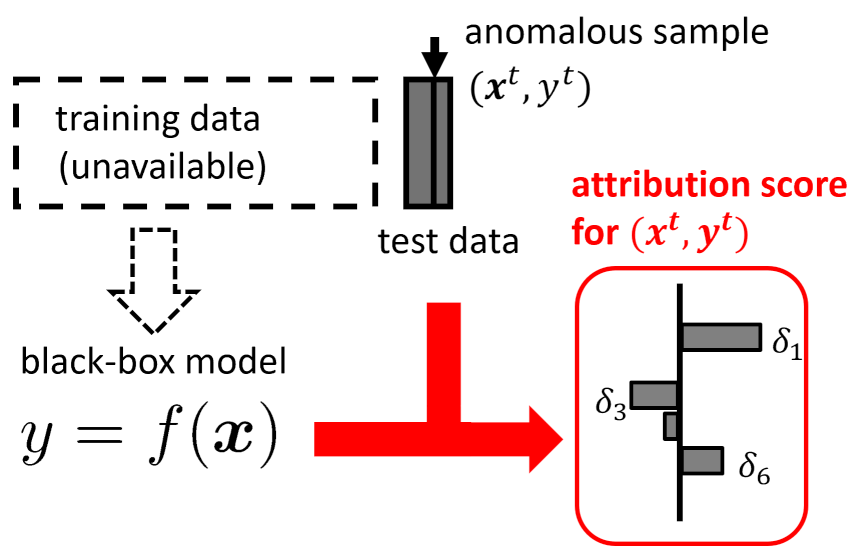

## What are existing methods? 

To the best of our knowledge, GPA is the first probabilistic anomaly attribution framework at the point of submission of the KDD paper. However, there are a few *non-probabilistic* black-box attribution methods that are potentially applicable to the task of anomaly attribution: 

1. Likelihood compensation (LC) [Ide et al. AAAI 21]
1. LIME [Ribeiro et al. KDD 16]
1. Integrated gradient (IG) [Sundararajan et al. ICML 20]
1. Expected integrated gradient (EIG) [Deng et al. AAAI 21]
1. Shapley values (SV) [Strumbelj & Kononenko KAIS 14]
1. Z-score: $Z_i = (x_i^t - m_i)/\sigma_i$


We have carefully implemented these methods along with GPA for comparison purposes. 

In the paper, we have mathematically shown a few very interesting properties of those existing methods.

1. LIME, SV, IG, and EIG are all *deviation-agnostic*. It does explain $f(\cdot)$ but cannot explain the deviation even when the target function is $f(\mathbf{x})-y$ rather than $f(\cdot)$.
1. SV is equivalent to EIG up to the second order of power expansion. 
1. LIME is equivalent to the derivative of IG and EIG.

For the details, please refer to the paper. I believe the first impossibility result is quite strong. 

---
# Demo: Anomaly Attribution on the Diabetes Dataset

## First, let's identify the top outlier.

We use a black-box regression function that has been pre-trained to predict the target variable called Progression, which is an index representing the progression stage of diabetes, from patient's attributes and biomarkers. The training process is described in [this notebook](Creating_black_box_model.ipynb).

### Loading a black-box model


In [1]:
%%time
# Reading the model
import os
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
import numpy as np
import pandas as pd
import gpa.gpa_util as util
import lzma 
import pickle

fn = 'Diabetes_data_and_model_seed50.pickle.xz'
path = os.getcwd() + '\\' + fn
with lzma.open(path, 'rb') as f:
    obj = pickle.load(f)

X_test = obj.get('X_test')
y_test = obj.get('y_test')

variable_names = obj.get('variable_names')
idxset_test = obj.get('idxset_test')
model = obj.get('model')


CPU times: total: 281 ms
Wall time: 3.23 s


### Computing anomaly score

predictive std dev. sigma_yf=54.29143364699173
63     99.0
68    132.0
67     52.0
16     67.0
9      68.0
61    230.0
53    292.0
71     77.0
39    121.0
50    265.0
dtype: float64
CPU times: total: 109 ms
Wall time: 260 ms


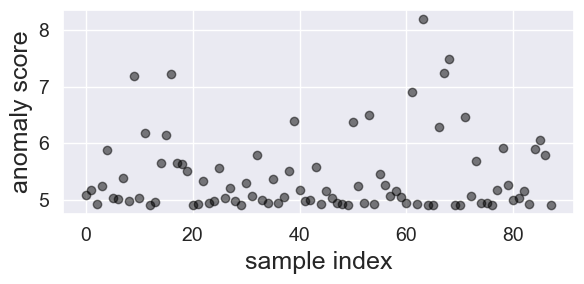

In [2]:
%%time
sigma_yf = (y_test - model.predict(X_test)).std()
print('predictive std dev. sigma_yf={}'.format(sigma_yf))
a = util.anomaly_score(X_test,y_test,model,sigma_yf=sigma_yf)


fig,ax=plt.subplots(figsize=(6,3))
x = np.arange(0,len(a))
ax.scatter(x,a,color='black',alpha=0.5)
ax.set_xlabel('sample index',fontsize=18)
ax.set_ylabel('anomaly score',fontsize=18)
ax.tick_params('x',labelsize=14)
ax.tick_params('y',labelsize=14)
fig.tight_layout()    

# Checking top 10 outliers
n_outliers = np.argsort(-a)[:10]
y_outliers = pd.Series(y_test[n_outliers],index = n_outliers)
print(y_outliers)

### How the top outlier #63 deviates from the population

CPU times: total: 109 ms
Wall time: 348 ms


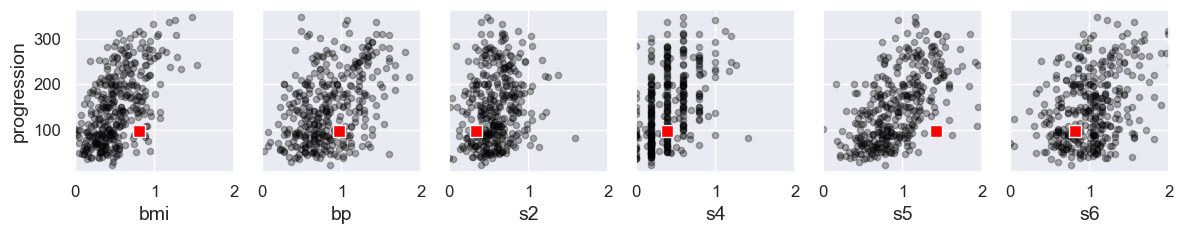

In [3]:
%%time
#################
n_test = [63]
test_x,test_y = X_test[n_test,:],y_test[n_test]
#################


# Just for visualization purposes, retrieve the training dataset
X_train = obj.get('X_train') 
y_train = obj.get('y_train')
variable_to_plot = ['bmi', 'bp', 's2', 's4', 's5', 's6']

fig,ax= util.plot_scatter_selected(variable_to_plot = variable_to_plot,
                                   variable_names = variable_names,
                                   X_train =X_train, y_train= y_train,
                                   figsize=(12,2.5),markerSize=20,
                                   test_x1=test_x, test_y1=test_y,
                                   test_x2=None, test_y2=None,
                                   ylim = None,xlim=(0,2),y_name = 'progression')

## Second, let's compare the anomaly attribution score of GPA with existing methods.

GPA is a probabilistic attribution method and its output is the probability distribution of attribution score. Here, for comparison with non-probabilistic existing methods, we treat the MAP estimate of GPA as the attribution score. In what follows, we will compute the following scores:

1. GPA's MAP value
1. Likelihood compensation (LC) [Ide et al. AAAI 21]
1. LIME [Ribeiro et al. KDD 16]
1. Integrated gradient (IG) [Sundararajan et al. ICML 20]
1. Expected integrated gradient (EIG) [Deng et al. AAAI 21]
    * Needs the training dataset.
1. Shapley values (SV) [Strumbelj & Kononenko KAIS 14]
    * Needs the training dataset.
1. Z-score: $Z_i = (x_i^t - m_i)/\sigma_i$
    * $x_i^t$ is the $i$-th entry of the test input, 
    * $m_i$ is the $i$-th entry of the mean (computed from the training data), and 
    * $\sigma_i$ is the standard deviation of the $i$-th input variable (computed from the training data). 


In [4]:
%%time
import gpa.gpa_lib as lib
import gpa.gpa_util as util
methods = []
scores = []

CPU times: total: 0 ns
Wall time: 2 ms


### GPA's MAP value

In [5]:
%%time
#----- GPA
N_grad = 10
l2 = 0.4*len(test_y)
l1_ratio = 0.5
lr = 0.08/len(test_y)
sigma_yf = (y_test - model.predict(X_test)).std()
eta=1
itr_max = 100

print('---------------- GPA')
methods = methods + ['GPA']
scale_fac = 10
a0 = 5. + len(test_y)/2.
b0 = a0*(sigma_yf**2) /scale_fac  

score_GPA, param_GPA = lib.gpa_map(X=test_x, y=test_y, model=model,
                                    a=a0, b=b0, l2=l2, l1_ratio=l1_ratio, 
                                    lr = lr, itr_max=itr_max, RAE_th=1e-3, 
                                    reporting_interval=10,
                                    N_grad=N_grad, eta_stddev = eta, seed_grad = 2, verbose=True)
scores = scores + [pd.Series(score_GPA, index=variable_names)]

---------------- GPA
  10: RAE(d)=0.325595,RAE(o)=0.030194, obj_value=20.984621711935354
  20: RAE(d)=0.002921,RAE(o)=0.000010, obj_value=19.439294911275546
  30: RAE(d)=0.001015,RAE(o)=0.000003, obj_value=19.438307347202567
finished:itr=  31: RAE(d)=0.000913,RAE(o)=0.000002, obj_value=19.438259282719965
CPU times: total: 15.6 ms
Wall time: 31 ms


### Likelihood compensation (LC) [Ide et al. AAAI 21]

In [6]:
%%time
#----- LC 
print('---------------- LC')
methods = methods + ['LC']
score_LC2, param_LC2 = lib.gpa_map_gaussian(test_x, test_y, model, 
                       stddev_yf=sigma_yf, l2=l2, l1_ratio=l1_ratio, lr=lr,
                       itr_max=itr_max, RAE_th=1e-3, reporting_interval=10,
                       N_grad =N_grad, eta_stddev=eta, seed_grad=2,verbose=True)
scores = scores + [pd.Series(score_LC2, index=variable_names)]

---------------- LC
  10: RAE(d)=0.007343,RAE(o)=0.000175, obj_value=18.914189425799545
  20: RAE(d)=0.001639,RAE(o)=0.000008, obj_value=18.906648125737558
finished:itr=  25: RAE(d)=0.000941,RAE(o)=0.000003, obj_value=18.90623661514868
CPU times: total: 15.6 ms
Wall time: 28 ms


### LIME [Ribeiro et al. KDD 16]


In [7]:
%%time
#----- LIME
print('---------------- LIME')
methods = methods + ['LIME']
l1_LIME = l1_ratio*l2
score_LIME,_ = util.LIME_deviation(test_x, test_y, model,
                                 N_grad=N_grad, eta=eta, l1=l1_LIME)
scores = scores + [pd.Series(score_LIME, index=variable_names)]

---------------- LIME
CPU times: total: 0 ns
Wall time: 2 ms


### Integrated gradient (IG) [Sundararajan et al. ICML 20]


In [8]:
%%time
#------ IG
print('---------------- IG')
methods = methods + ['IG']
N_alpha = 100
xbase = np.zeros(X_test.shape[1])
score_IG = util.IG_vec(xtest=test_x, xbase=xbase, model=model, 
                          eta=eta, N_alpha = N_alpha, N_grad=N_grad,
                          seed=0)
scores = scores + [pd.Series(score_IG, index=variable_names)]

---------------- IG
CPU times: total: 15.6 ms
Wall time: 24.3 ms


### Expected integrated gradient (EIG) [Deng et al. AAAI 21]


In [9]:
%%time
#------ EIG
print('---------------- EIG')
methods = methods + ['EIG']
score_EIG = util.EIG_vec(x_test=test_x, Xtrain=X_train, model=model, 
                    eta=eta, N_alpha = N_alpha, N_grad=N_grad,
                    seed=0)
scores = scores + [pd.Series(score_EIG, index=variable_names)]

---------------- EIG
CPU times: total: 7.53 s
Wall time: 2.74 s


### Shapley values (SV) [Strumbelj & Kononenko KAIS 14]

In [10]:
%%time
#------ SV 
print('---------------- SV')
methods = methods + ['SV']
score_SV = util.SV(xtest = test_x, Xtrain = X_train, model=model,seed=1)
scores = scores + [pd.Series(score_SV, index=variable_names)]

---------------- SV
..done
CPU times: total: 906 ms
Wall time: 941 ms


### Z-score: $Z_i = (x_i^t - m_i)/\sigma_i$

In [11]:
%%time
#----- Z-score
print('---------------- Z')
methods = methods + ['Z']
X_means = X_train.mean(axis=0)
X_stdev = X_train.std(axis=0)
score_Z = (test_x.ravel() - X_means)/X_stdev
scores = scores + [pd.Series(score_Z, index=variable_names)]

---------------- Z
CPU times: total: 15.6 ms
Wall time: 999 µs


### Visualizing the results with the `Litmus Plot`

In [12]:
#==== Saving the result into df 
df = pd.concat(scores,axis=1).T
df.index = methods   
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
GPA,0.000000,0.000000,-0.805635,-0.264785,0.116661,0.000000,-0.003986,-0.233995,-0.553114,0.000000
LC,0.000000,0.000000,-0.664687,-0.230959,0.095530,0.000000,0.000000,-0.221315,-0.543104,0.000000
LIME,-31.153211,28.122105,96.422190,45.649794,22.725144,9.033151,-0.000000,-0.000000,44.557067,20.419026
IG,2.127118,-0.000000,62.858227,39.023671,-9.562016,-1.850425,-0.980027,14.903931,89.674457,3.009604
EIG,2.308311,8.957915,24.525817,4.933787,3.318513,2.790029,1.093416,0.290891,36.966747,-0.019712
SV,1.332536,10.335526,26.892355,5.118445,3.207224,2.724062,1.685871,0.611953,40.238539,-0.313762
Z,-0.660042,-0.929063,1.015202,0.344339,-0.352952,-1.013178,-0.006935,-0.031175,1.376697,-0.543644


working on the litmus plot....
CPU times: total: 1.17 s
Wall time: 2.52 s


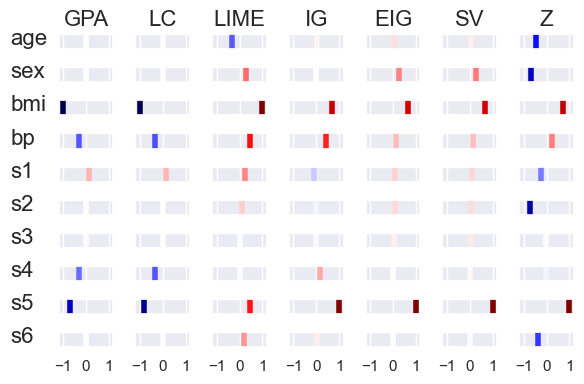

In [13]:
%%time

print('working on the litmus plot....')
variable_to_plot = variable_names
figsize = (6,4)
score_absmax = df.abs().max(axis=1)
num_gridpoints = 100 
bw_ratio = 5
margin_ratio = 1.2
font_title = 16
font_label = 16
y_labelpad = 35

data= df.copy()

#--------
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
import pandas as pd
import numpy as np

cmap = plt.get_cmap('seismic',500) 

fig, ax = plt.subplots(len(variable_to_plot),len(methods),
                       figsize=figsize,sharey=True,sharex=True)

for jj, method in enumerate(methods):  

    for ii, vname in enumerate(variable_to_plot):
        # Adjusting the axes
        ax[ii,jj].set_xlim(-margin_ratio,margin_ratio)

        ax[ii,jj].tick_params(axis='y',labelleft=False)
        if ii == 0:
            ax[ii,jj].set_title(method,fontsize = font_title)
        if jj == 0:
            ax[ii,jj].set_ylabel(vname,fontsize=font_label,loc='bottom',
                                 rotation=0,labelpad =y_labelpad)
        if vname == variable_to_plot[-1]:
            ax[ii,jj].tick_params(axis='x',labelbottom=True)


        # Plotting ...
        x= data[vname][method]/score_absmax[method]
        x_color = (x+1.)/2.
        ax[ii,jj].axvline(x,color=cmap(x_color),linewidth=4)


fig.tight_layout()

Notice how EIG and SV scores are remarkably similar. This result stems from Theorem 4 in our paper, where we show that, despite different definitions, the expected integrated gradient (EIG) is equivalent to the Shapley value up to the second order of power expansion.

Additionally, you might have observed that the MAP values of GPA closely align with the LC's score. This alignment can be formally proven by demonstrating that the $t$-distribution converges to a Gaussian distribution when the degrees of freedom are large.

## Finally, let's check the estimated distribution of the attribution score. 

The ability to compute the distribution of attribution scores is the most important and unique feature of the proposed GPA algorithm. This distribution reveals the perturbation amount that achieves the highest likelihood given the observed $y=y^t$ and quantifies the associated uncertainty.

Additionally, the distribution provides valuable insights into a variable's informativeness for prediction. When a variable has minimal predictive power, GPA generates a very flat distribution around the MAP value at zero, driven by the L1 regularization. A flat $f(\cdot)$ along a variable $x_i$ indicates that the variable has negligible influence on the observed deviation, resulting in a negligible attribution score. This aligns with traditional sensitivity analysis and LIME-like algorithms.

In the figure, $q_k(\delta_k)$ represents the distribution of the attribution score $\delta_k$ for the $k$-th variable. Thanks to the variational-Bayes-like formulation, GPA conveniently provides a set of variable-wise distributions $q_1(\cdot),\ldots, q_M(\cdot)$.

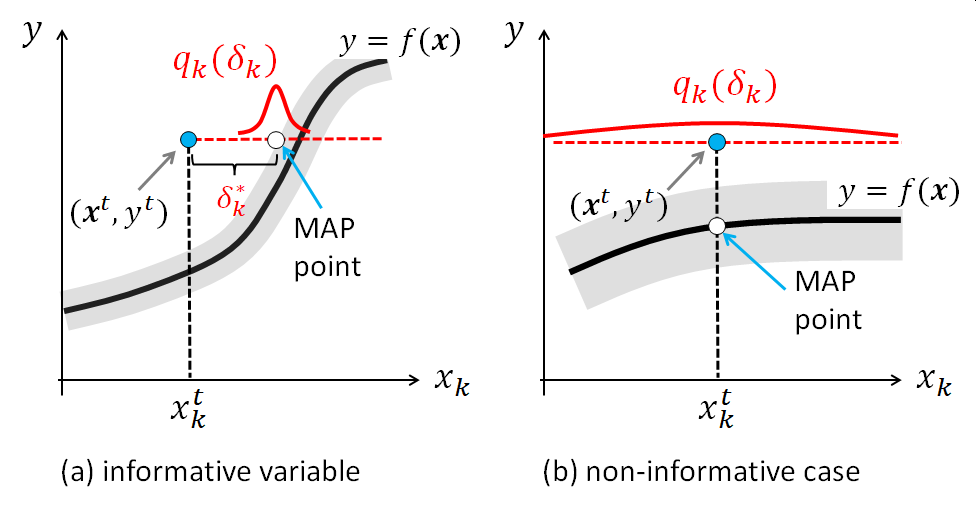

### Re-computing MAP estimate and estimating the distribution of the attribution score.

In [14]:
%time
# For demo purposes, let's recompute the MAP estimate
score_GPA, param_GPA = lib.gpa_map(X=test_x, y=test_y, model=model,
                                    a=a0, b=b0, l2=l2, l1_ratio=l1_ratio, 
                                    lr = lr, itr_max=itr_max, RAE_th=1e-3, 
                                    reporting_interval=10,
                                    N_grad=N_grad, eta_stddev = eta, seed_grad = 2, verbose=True)


# Then, let's find the distribution
dist,sgrid =  lib.gpa_dist(delta_MAP=score_GPA,X=test_x,y=test_y,model=model,
                         a=a0,b=b0,l2=l2,l1_ratio=l1_ratio,N_grid = 100)

CPU times: total: 0 ns
Wall time: 0 ns
  10: RAE(d)=0.325595,RAE(o)=0.030194, obj_value=20.984621711935354
  20: RAE(d)=0.002921,RAE(o)=0.000010, obj_value=19.439294911275546
  30: RAE(d)=0.001015,RAE(o)=0.000003, obj_value=19.438307347202567
finished:itr=  31: RAE(d)=0.000913,RAE(o)=0.000002, obj_value=19.438259282719965


### Visualizing the result

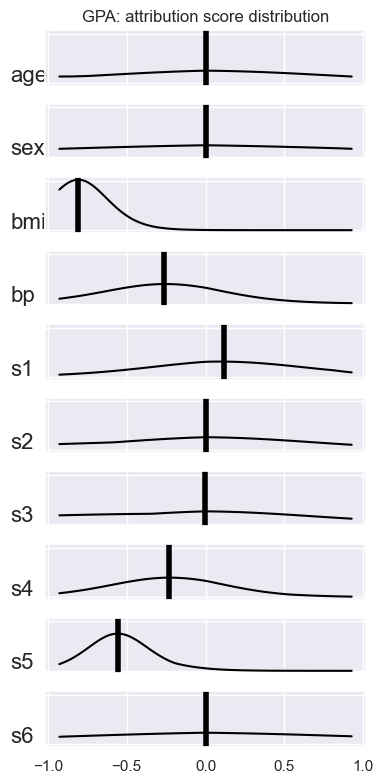

In [15]:
M = test_x.shape[1]
font_label =16
y_labelpad = 25
fig,axes= plt.subplots(M,1,sharex=True,sharey=True,figsize=(4,8))
title_string = 'GPA: attribution score distribution'
for idx,ax in enumerate(axes):
    if idx ==0:
        ax.set_title(title_string,fontsize=12)
    v_name = variable_names[idx]
    ax.tick_params(axis='y',labelleft=False)
    ax.set_ylabel(v_name,fontsize=font_label,loc='bottom',
                         rotation=0,labelpad =y_labelpad)
    ax.axvline(score_GPA[idx],color='black',linewidth=4)
    ax.plot(sgrid,dist[idx,:],color='black',label=v_name)  

fig.tight_layout()    